# Juliaで強化学習Tutorial

ここではJuliaのコーディングを学びながら強化学習の問題設定・アルゴリズムについて学んで行くためのTutorialを書き記す。

教科書のおすすめは[強化学習(森村哲郎)(以下クジラ本と呼ぶ。)](https://www.amazon.co.jp/%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92-%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%83%97%E3%83%AD%E3%83%95%E3%82%A7%E3%83%83%E3%82%B7%E3%83%A7%E3%83%8A%E3%83%AB%E3%82%B7%E3%83%AA%E3%83%BC%E3%82%BA-%E6%A3%AE%E6%9D%91-%E5%93%B2%E9%83%8E/dp/4065155916/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=3SWHHJD58U62A&keywords=%E6%A3%AE%E6%9D%91%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92&qid=1703212182&sprefix=%E6%A3%AE%E6%9D%91+%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%2Caps%2C242&sr=8-1)と[ゼロから作るデープラーニング4-強化学習-(斎藤興毅)](https://www.amazon.co.jp/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BDeep-Learning-%E2%80%95%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%E7%B7%A8-%E6%96%8E%E8%97%A4-%E5%BA%B7%E6%AF%85/dp/4873119758/ref=sr_1_1?__mk_ja_JP=%E3%82%AB%E3%82%BF%E3%82%AB%E3%83%8A&crid=3QBRFO7FQGHEO&keywords=%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8B%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92&qid=1703212249&sprefix=%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8B+%E5%BC%B7%E5%8C%96%E5%AD%A6%E7%BF%92%2Caps%2C266&sr=8-1)である。理論的な部分は、森村さんのクジラ本が丁寧に書いてある。とはいえコード実装例とかは乏しいので、ゼロ作等で補完すると良いだろう。それより最近の話題については論文とそれに付属のソースコードを見る事を勧める。(上記２冊を読めば、そんなに困らずに読めるはず。)特にDeepMind様のソースコードは読みやすい気がするのでオススメ。

０章は導入のため、完全にお話になっていて、Juliaによるコーディングは１章の終盤から始まり、ニューラルネットを用いた強化学習のコーディングは２章から始まる。

## 0. 強化学習の問題設定

強化学習とは、環境(与えられるタスクと報酬体系)とエージェント(タスクをこなすための戦略(Policy)を持っている存在)からなる系である。
エージェントは環境の状態(の一部)を知ることが出来、環境に対して何かしらの行動を取ることで報酬を得ることが出来る。(問題によっては行動によって環境の状態を変化させることが出来る。)
「(エージェントが最初に環境の情報を知らない状態からスタートし、試行錯誤を繰り返すうちに)ある環境の中で目的関数(最終的に得られる報酬和など)を最大化するような戦略(一連の行動手順)を見つける」という問題を強化学習と呼ぶ。

ふんわりとした数式で一旦定義しておこう。

環境$\mathcal{E}$は
 $$ \mathcal{E} = \{\mathcal{A} , \mathcal{S}, p_T(s_{t+1}|\{s_t\},\{a_t\}) , r(\{a_t\},\{s_t\})\}, \\
  (\{s_t\} = \{s_0, s_1, \dots, s_t\}, \{a_t\} = \{a_1, \dots, a_t\}, s_t,s'\in \mathcal{S}, a_t\in\mathcal{A} )$$
で書くことが出来る。$\mathcal{A}$はエージェントの取ることが出来る行動空間であり、$\mathcal{S}$は環境の取りうる状態空間, $p_T(s_{t+1}|\{s_t\},\{a_t\})$は状態$s_t$の時に行動$a_t$をとった時に次の遷移した状態が$s_{t+1}$である確率である。$g(a,s)$は状態sの時にエージェントが行動aを起こした時にエージェントに与えられる報酬である。これらが定義されているのが環境である。

一方で、エージェントとは(一般に確率的な行動指針)ポリシー$\pi$を持っていて、
 $$ p_a = \pi(a|\{\bar{s}_t\}, \{a_{t-1}\}) \ \ \ \ \sum_a p_a = 1$$
と書ける。エージェントの観測できる環境の状態(の一部)の時系列が$\{s_t\}$,自分の今までの行動が $\{a_{t-1}\}$の時に行動aを$p_a$の確率で取るという戦略になっている。エージェントも決定的な行動をとる場合は、$p_a$はone-hotベクトル(ある一つの要素が1でそれ以外が0)
一般には、エージェントの観測できる環境の状態は一部であり($\mathrm{dim}|\bar{s}| < \mathrm{dim}|s|$)、そのような問題は部分観測問題と呼ばれるが、今回は着目しない。

強化学習の問題とは、エージェントが$\pi$に従って行動を行なっていった際の何かしらの目的関数$f$の期待値$E_{\pi}[f]$を最大化するような最適な方策$\pi$を見つける問題である。


ここで例を考えてみよう。

コンビニにおやつを5回買いに行って１回当たり１個おやつを買うことが出来る。コンビニには見た事のない３種類のおやつがあり、最初味はわからないとする。5回の購入の総合満足度を最大化したい。

最初の購入は、情報が全くないのでランダムだが、例えばAのお菓子を買ったとし、それが不味く満足度-2としよう。

次の購入では多くの場合、別のお菓子を買ってみるだろう。ここでBのお菓子を買い、その満足度が+5だとする。
さてここで残り３回の購入でCを試すかどうかである。Cの満足度はBより高く+10かもしれないし、Aよりもひどく-10かもしれない。それだったらBを３回買って満足するのが良いのかもしれない。

強化学習の立場では、ここでCを買ってみる事を「探索」と呼び、Bを買い続ける事を「活用」と呼ぶ。より一般的には、「データをもっと集めるべきとし、新しい選択肢を選ぶ事」と「今あるデータを十分とし利用する事」である。

この「探索」と「活用」をどのようなバランスで行なっていき最善戦略を見つけるかが強化学習の難しさである。

(注：既にデータを準備した状態で報酬を最大化するようにデータの中での最善方策を考える問題もある。)

## 0-1. 強化学習の分類

ここで、強化学習の問題についてそれぞれの設定による分類をしておこう。

環境側の分類として状態遷移確率と報酬関数がそれぞれマルコフ的である時($p_t(s_{t+1}|\{s_t\}, \{a_{t}\}) = p_t(s_{t+1}|s_t, a_t)$, $r(\{s_t\}, \{a_{t}\}) = r(s_t,a_t)$)、これをマルコフ決定過程(Markov Decision Process)と呼ぶ。

環境の$r, p_t$が既知の場合(つまり既に探索は終わっていて、活用のみをすれば良い時)、その問題をプランニング問題と呼ぶ。これは狭義の強化学習には含まれない。

次に$r, p_t$が未知の場合を考える。これが狭義の強化学習である。この場合はエージェントの方策によって分類をするべきであろう(未知のもので分類することに意味はないので)。
エージェントの方策が直前の状態のみに依存する場合($\pi(a_{t}|\{s_t\}, \{a_{t-1}\}) = \pi(a_t|s_t)$)、マルコフ方策問題と呼び、そうでない場合は、非マルコフ方策問題と呼ぶ。さらに方策が決定論的$\pi(a_t|) = \delta_{a_t, a^*}$な場合は、決定的方策、そうでない場合は確率的方策と呼ぶ。
この呼び方はプランニング問題にも適用できる。

また方策のアップデートの仕方について、データをそれなりに集めて方策をアップデートする場合はオフライン学習(バッチ学習)と呼ばれ、集めながら方策も同時に更新していくやり方をオンライン学習と呼ぶ。


また強化学習のエージェントの内部に、環境モデルを推定するアーキテクチャがあるかないかで、モデルベースド/モデルフリーの強化学習という分類もある。



以降では、マルコフ決定過程の問題について考えていく。


## 1. プランニング問題

まず環境について報酬関数$r(\{s_t\}, \{a_t\})$や状態遷移確率$p_t(s_{t+1}|\{a_t\},\{s_t\})$が既知であるとして、エージェントが最善方策をどのように導くかという問題について考える。ここでの内容は(環境が未知の場合の)狭義の強化学習にも応用できるので学んでおこう。



### 1-1. マルコフ方策の十分性
前節で方策についての分類を行ったが、基本的に非マルコフ方策は考えるべき次元が膨大になる($|\mathcal{A}\mathcal{S}|^t$)のであまり考えたくない。そこで、マルコフ決定過程においては、目的関数が以下の性質を満たせば、マルコフ方策を考えそれを最適化すれば十分である事を示す。(マルコフ決定過程ならマルコフ方策だけで十分なのは当たり前のように感じるかもしれないので後で反例を挙げておく)

方策$\pi$に従って行動した際の時刻tでの(s,a)の周辺確率を$\phi_t^{\pi}(s,a|s_0)$とすると、目的関数が



### 1-2. 価値関数とベルマン方程式

前節で定義したリターン$C_{t_0} = \sum_{t=0}^{t_f} \gamma^t r_{t_0+t}$を目的関数とする場合を考えていく。すなわち
$$
f(\pi) = E_\pi[C_0|s_0]
$$
を最大化する方策$\pi$を見つけたい。ここで状態価値関数$V(s)$を以下で定義しておく。

$$
V^{\pi}(s) = E_{\pi}[C_0|s_0=s]
$$

と$f(\pi) = E_\pi[C_0|s_0] = V^{\pi}(s_0)$なので$V(s)$の最適化を考えれば良い。
ここで以下の式が成り立つ。

$$
\begin{aligned}
V^*(s_0) &= \mathrm{max}_{\pi} V^{\pi}(s_0) \\
    &= \mathrm{max}_{\pi} [E^{\pi} [C_0|s_0]] \\
    &= \mathrm{max}_{\pi} [E^{\pi} [(g(s_0, a_0) + \gamma C_1)|s_0]] \\
    &= \mathrm{max}_{\pi} [\sum_{a_0} \pi(a_0|s_0)\{g(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{\pi}(s_1)\}] \\
    &= \mathrm{max}_{a_0} [\{g(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{*}(s_1)\}]
\end{aligned}
$$

上式は$V^{\pi}(s)$についての再帰的な方程式になっており、関数についての作用素(ベルマン作用素)$B_*$を用いて、$V^* = B_*V^*$と書ける。これをベルマン方程式と呼ぶ。

また$V^{\pi}(s)$自体にも、以下のベルマン方程式が成り立つ。($V^\pi = B_\pi V^\pi$)
$$
V^{\pi}(s_0) =  \sum_{a_0} \left[\pi(a_0|s_0)\left\{g(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{\pi}(s_1)\right\}\right] 
$$

### 1-3. (余談)ベルマン方程式と最小作用の原理

状態価値関数についてのベルマン方程式なるものが登場したわけだが我々物理学徒はこれに似たものを知っている。最小作用の原理である。

ラグランジュ形式において、作用は以下の形で書ける。
$$
 S[x|x_0,t_0] = \int_{t_0}^{t_f} dt L(x,\dot{x},t) \simeq L(x_0, \dot{x}, t_0)\delta t + S[x|x_0+\dot{x}_0\delta t,  t_0+\delta t]
$$
これをxについて最小化するような条件からオイラー・ラグランジュ方程式(運動方程式)が出てくるわけである。(つまり$\mathrm{min}_xS[x]$を解きたい)

ここで前章で出てきたベルマン方程式と見比べてみると、
$$
V^*(s_0) = \mathrm{max}_{\pi}V^{\pi}(s_0) \Rightarrow \mathrm{min}_{\{x_t\}}S[x|x_0, t_0],\\
g(s_0,a_0) \Rightarrow L(x,\dot{x}, t_0)\delta t,\\
p_t(s_1|s_0, a_0) = \delta(x_1 - (x_0 + \dot{x_0}\delta t)),\\
\gamma=1
$$
とすれば、対応することがわかる。

逆に言えば、ベルマン方程式はラグランジュ形式の作用を少し一般化して$\tilde{L}(x,\dot{x}, t) = e^{-\gamma t}L(x,\dot{x}, t)$として確率過程の作用(ラグランジアン)を考えている事になる。$0<\gamma<1$の場合は、何かしらの散逸項が付いている場合の確率過程の作用と考えれば良いだろう。

という事は、同様にベルマン方程式の停留条件からオイラー・ラグランジュ方程式の導出も出来る。ベルマン方程式において、エージェントは速度を決定する行動を取れるとすると(つまり、$a_t = \dot{s}_t$とすると、)、ベルマン方程式は、
$$
\begin{aligned}
V^{*}(s_0) &= \mathrm{max}_{a_0} [\{g(s_0, a_0) + \gamma \sum_{s_1}p_t(s_1|s_0, a_0) V^{*}(s_1)\}] \\
    &= \mathrm{max}_{a_0} \left[\left\{L(s_0, a_0)\delta t + \gamma \left(V^{*}(s_0) + \frac{\partial V^*}{\partial s} a_0 \delta t\right)\right\}\right] \\
\Rightarrow (1-\gamma)V^{*}(s_0) &= \mathrm{max}_{a_0} \left[L(s_0, a_0) + \gamma \left(\frac{\partial V^*}{\partial s}\right) a_0\right]\delta t\\
\\
\Rightarrow &\frac{\partial L}{\partial a} + \int dt \gamma^{t+1}\left(\frac{\partial L}{\partial s}\right) = 0\\
\Rightarrow &\frac{d}{\gamma dt}\left(\frac{\partial L}{\partial a}\right) +  \gamma^{t}\left(\frac{\partial L}{\partial s}\right) = \frac{d}{\gamma dt}\left(\frac{\partial L}{\partial \dot{s}}\right) + \gamma^{t} \left(\frac{\partial L}{\partial s}\right) = 0
\end{aligned}
$$

４行目の導出が停留条件であり、５行目が($\gamma=1$で)オイラー・ラグランジュ方程式である。($\gamma=1-\eta$として$\gamma^t \simeq e^{-\eta t}$とすれば、散逸ありの運動方程式)
よって、ベルマン方程式を解く事は、強化学習における状態の軌跡(運動方程式)を解く事に他ならない。



### 1-4. (価値観数についての)ベルマン作用素の縮小性と解の一意性

さて前節で、ベルマン方程式と最小作用の原理の対応についてみた際に、「$\gamma=1$で良いのでは？」と思ってしまった方も居るかもしれない。しかしγを１以下にしておく事でベルマン作用素の縮小性と解の一意性と保証することが出来、それにより次の章で行うような動的計画法による解法を用いることが出来る。

$v_0(s)= V^\pi(s) + d(s)$とすると、
$$
\begin{aligned}
v'(s) = B_\pi v(s) &= \sum_{a} \left[\pi(a|s)\left\{g(s, a) + \gamma \sum_{s'}p_t(s'|s, a) v_0(s')\right\}\right] \\
    \Rightarrow v'(s)-V^\pi(s) &= \gamma\sum_{a, s'}\pi(a|s)p_t(s'|s, a) \left(v_0(s')-V^{\pi}(s')\right)\\
    \Rightarrow |d'(s)| &\leq \gamma\sum_{a, s'}\pi(a|s)p_t(s'|s, a) |v_0(s')-V^{\pi}(s')|\\
    &\leq \gamma \mathrm{max}_{s'}|d(s')|\\
    \Rightarrow \mathrm{max}_{s}|B_\pi d(s)| &\leq \gamma \mathrm{max}_{s}|d(s)|
\end{aligned}
$$

が成立するため、($0<\gamma<1$ならば)ベルマン作用素$B_\pi$を作用させる度に、ベルマン作用素の固有関数(すなわち真の価値関数)との差は縮小していく。これは$B_*$についても同様に証明が出来る。またこの縮小性から、解の一意性も証明することが出来る。

### 1-5. 動的計画法

$V^*(s)$が分かれば、最善方策$\pi_*(a|s)$はベルマン方程式を用いて、
$$
\pi_*(a|s) = \delta_{a,a^*},\\
a^* = \mathrm{argmax}_a \left[g(s,a) + \gamma \sum_{s'} p_T(s'|s,a)V^*(s')\right] 
$$
で与えられる。

前節において価値関数についてのベルマン方程式の縮小性と解の一意性があることがわかった。よって適当な価値関数からスタートして、最適価値関数についてのベルマン作用素を作用させ続ければ、真の最適価値関数に収束し、そこから最善方策を導くことが出来る。これを価値反復法と呼ぶ。

### 1-5-1. 価値反復法の実装
ようやくJulia Partである。実装してみよう。以下のようなゲームを考える。手札を消費して得点を得るカードゲームのようなものを考える。手札を２枚消費する事でその時持っていた枚数に応じて得点を得られる。４枚消費で大量得点をする事も出来る。手札がの時は、ポイントを消費して、手札消費の代わりに手札入れ替えが出来る。またポイントを支払う事で、手札を補充する事も出来る。手札の最大枚数は５枚とし、初期手札枚数は1,3,5から始まるとする。

上記のゲームは以下のような図で表される。
これをベルマン作用素を繰り返し作用させる、価値反復法で解いてみよう。

In [1]:
using LinearAlgebra

In [2]:
#環境の定義
struct Env_duel
    s_dim::Int
    a_dim::Int
    g::Matrix{Float32} #報酬関数 reward matrix[action, state]
    pt::Array{Float32, 3} #状態遷移確率 transion function [action, state, next state]
end

function init_envd()
    s_dim::Int = 3
    a_dim::Int = 2
    g = Float32[-6 -2 10; -2 2 5]
    pt = zeros(Float32, a_dim, s_dim, s_dim)
    pt[1, :, :] = [0.0f0 1.0f0 0.0f0; 0.0f0 0.0f0 1.0f0; 1.0f0 0.0f0 0.0f0]
    pt[2, :, :] = [1.0f0 0.0f0 0.0f0; 1.0f0 0.0f0 0.0f0; 0.0f0 1.0f0 0.0f0]
    
    return Env_duel(s_dim, a_dim, g, pt)
end

init_envd (generic function with 1 method)

In [3]:
# エージェント(プレイヤー)の定義
mutable struct Duelist
    policy::Matrix{Float32} #方策[a|s]
    γ::Float32 #割引率
    valuefn::Vector{Float32} #価値関数[s]
end

function init_agt(en::Env_duel,γ::Float32)
    policy = zeros(Float32, en.a_dim, en.s_dim)
    policy[2,:] = ones(Float32, en.s_dim)
    valuefn = zeros(Float32, en.s_dim)
    return Duelist(policy, γ, valuefn)
end

init_agt (generic function with 1 method)

In [4]:
#ベルマン作用素を作用させ、価値関数をアップデート
function value_update!(en::Env_duel, ag::Duelist)
    old_vfn = ag.valuefn
    for s in 1:en.s_dim
        ag.valuefn[s] = maximum(en.g[:,s] + ag.γ*en.pt[:,s,:]*old_vfn)
    end
end

value_update! (generic function with 1 method)

In [5]:
#価値関数から決定的方策を導出
function best_policy!(en::Env_duel, ag::Duelist)
    for s in 1:en.s_dim
        best_action = argmax(en.g[:,s] + ag.γ*en.pt[:,s,:]*ag.valuefn)
        ag.policy[:,s] = zeros(Float32, en.a_dim)
        ag.policy[best_action,s] = 1.0f0
    end
end

best_policy! (generic function with 1 method)

In [6]:
en = init_envd()
ag = init_agt(en, 0.98f0)
n_itr = 100
vs = zeros(Float32, n_itr, en.s_dim)
pol1 = zeros(Int, n_itr)
for itr in 1:n_itr
    value_update!(en, ag)
    vs[itr,:] = ag.valuefn
    best_policy!(en, ag)
    pol1[itr] = argmax(ag.policy[:,1])
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)

Float32[64.457214, 71.948074, 75.50912]
Float32

[1.0 1.0 0.0; 0.0 0.0 1.0]


In [7]:
using Plots

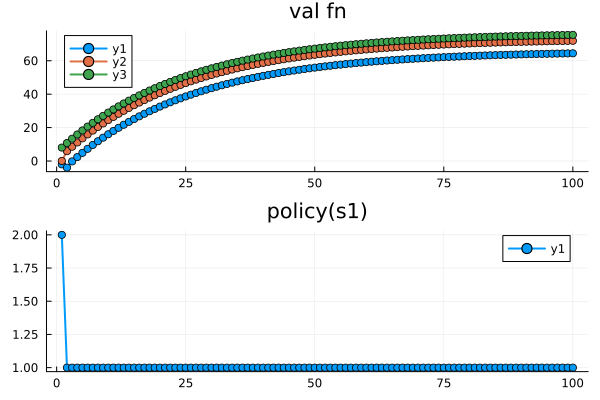

In [8]:
p1 =plot(vs, lw = 2.0, marker=:circle, title="val fn")
p2 = plot(pol1, lw = 2.0, marker=:circle, title="policy(s1)")
plot(p1, p2, layout=(2,1))

$\gamma$が小さい方が収束自体は早い

Float32[5.8420954, 13.157885, 16.842094]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


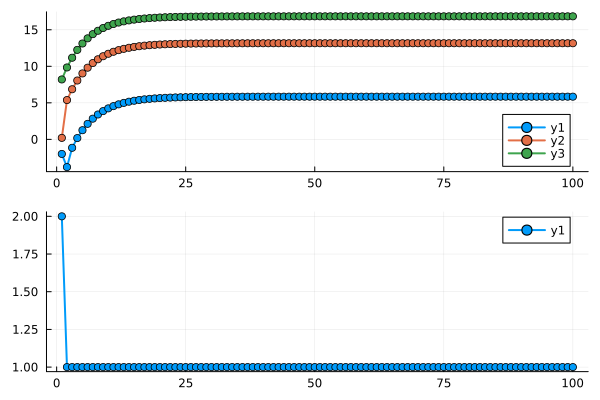

In [9]:
ag = init_agt(en, 0.9f0)
n_itr = 100
vs = zeros(Float32, n_itr, en.s_dim)
pol1 = zeros(Int, n_itr)
for itr in 1:n_itr
    value_update!(en, ag)
    vs[itr,:] = ag.valuefn
    best_policy!(en, ag)
    pol1[itr] = argmax(ag.policy[:,1])
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)
p1 =plot(vs, lw = 2.0, marker=:circle)
p2 = plot(pol1, lw = 2.0, marker=:circle)
plot(p1, p2, layout=(2,1))

一方で小さすぎると、未来の報酬が見えず、間違った方策を作るようになる(悪い価値関数の定義になってしまう)。下は$\gamma=0.5$にした場合の例。最善方策の収束先が違っている。

実際の計算では一般に$\gamma$をどれくらいにするのが適切かわからないので、経験的に$0.95\sim 0.99$くらいにする事が多い。(僕の経験ではなく、多くの論文の設定として)

Float32[-4.0, 2.0, 8.0]
Float32[0.0 1.0 1.0; 1.0 0.0 0.0]


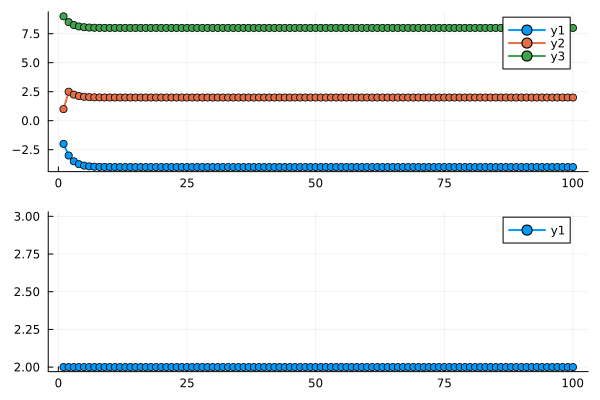

In [10]:
ag = init_agt(en, 0.5f0)
n_itr = 100
vs = zeros(Float32, n_itr, en.s_dim)
pol1 = zeros(Int, n_itr)
for itr in 1:n_itr
    value_update!(en, ag)
    vs[itr,:] = ag.valuefn
    best_policy!(en, ag)
    pol1[itr] = argmax(ag.policy[:,1])
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)
p1 =plot(vs, lw = 2.0, marker=:circle)
p2 = plot(pol1, lw = 2.0, marker=:circle)
plot(p1, p2, layout=(2,1))

次に方策反復法も知っておこう。方策反復法は、「ある方策の下での価値関数を最大化し、その後方策を価値関数に基づいてアップデートする事を繰り返す方法」である。

In [11]:
#ベルマン作用素を作用させ、価値関数をアップデート
function value_update_pi!(en::Env_duel, ag::Duelist)
    old_vfn = ag.valuefn
    for s in 1:en.s_dim
        #ここの更新の仕方が最適価値関数(のベルマン作用素)の場合と異なる。
        ag.valuefn[s] =  ag.policy[:,s]'*(en.g[:,s] + ag.γ*en.pt[:,s,:]*old_vfn)
    end
end

value_update_pi! (generic function with 1 method)

Float32[5.8420954, 13.157885, 16.842094]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


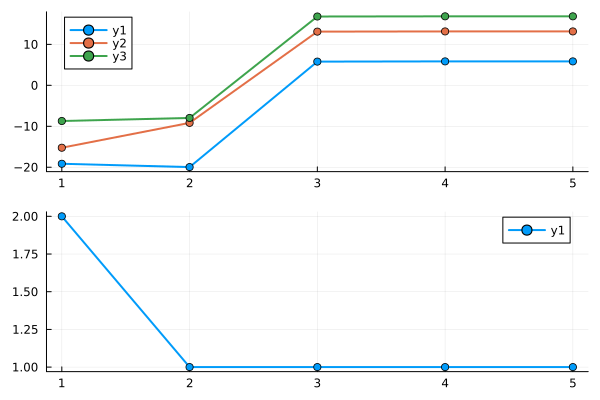

In [12]:
ag = init_agt(en, 0.9f0)
n_itr = 30
pu = 5
vs = zeros(Float32, pu, en.s_dim)
pol1 = zeros(Int, pu)
for i in 1:pu
    for itr in 1:n_itr
        value_update_pi!(en, ag)
    end
    vs[i,:] = ag.valuefn
    best_policy!(en, ag)
    pol1[i] = argmax(ag.policy[:,1])
end
println(ag.valuefn)
best_policy!(en, ag)
println(ag.policy)
p1 =plot(vs, lw = 2.0, marker=:circle)
p2 = plot(pol1, lw = 2.0, marker=:circle)
plot(p1, p2, layout=(2,1))

ここでは愚直にやったが、value_update_pi!の部分をitrを回さずに解析的に(逆行列計算して)一発で$V^{\pi}(s)$を計算する方法があるので、方策反復法の方が速かったりもする。(その場合上記のように3回方策更新するだけで最善方策にたどりつく)(詳しくは森村さんのクジラ本を見よう！)

### 3. 強化学習

さてようやく狭義の強化学習に取り掛かろう！狭義の強化学習においては、環境の持っている報酬関数$g(s,a)$と状態遷移確率$p_t(s'|s,a)$をエージェントは知らないので、ベルマン作用素がわからない状態である。そこで探索して情報を集め、その近似的な(標本近似した)ベルマン作用素を作り最適方策を導いていく事になる。

まず行動価値関数Qを定義する。言葉通り、状態sにおいて行動aを取る価値であり、
$$
V^{\pi}(s) = \sum_a \pi(a|s) Q(s,a)\\
Q^{\pi}(s,a) = g(s,a) + \gamma\sum_{s'}p_t(s'|s,a)V^{\pi}(s')
$$
これはある種、環境の状態遷移確率を価値関数に取り込んだ関数になっている。
価値関数についてのベルマン方程式と同様にして、行動価値関数についてもベルマン方程式を書く事が出来、
$$
Q^{\pi}(s,a) = g(s,a) + \gamma\sum_{s', a'} p_t(s'|s,a) \pi(a'|s') Q(s', a') \\
\Rightarrow Q^{\pi} = B_Q Q^{\pi}
$$
となる。同様にして、最適価値関数に関するベルマン方程式は、
$$
Q^{*}(s,a) = g(s,a) + \gamma\mathrm{max}_a'\sum_{s', a'} p_t(s'|s,a) Q^*(s', a') \\
\Rightarrow Q^{*} = B_{Q*} Q^{*}
$$
1-4節で示したのと同様にして、$B_Q, B_{Q*}$についても縮小性と解の一意性が言える。

### 2-1. 行動価値関数についてのベルマン作用素の標本近似の収束性

### 2-2. $\epsilon$-greedy法

さて今は狭義の強化学習について考えているので、探索行動を取るための指針が必要である。
ここでは探索行動はランダムとする$\epsilon$-greedy法について見ていこう。

もしも正しい行動価値関数$Q(s,a)$が分かっているとすると、
$$
\pi(a|s) = \delta_{a,a^*} \ (a^* = \mathrm{argmax}_a Q(s,a))
$$
で行動するのが最善方策である。一方で正しいQを得るためには、探索行動をして、(例えば$g(s,a)$などを実際に経験して)Qをアップデートしなければならない。
基本的には自身の持っている情報から最善行動をしなければ最適行動価値関数$Q^{*}$はベルマン方程式から求められないが、新しい情報を得るためには、それ以外の行動も試す必要がある。

そこで、最善と思っている行動以外を試す事をある確率でランダムに行う手法が$\epsilon$-greedy法である。
現状得られいる行動価値関数から
$$
\pi(a|s) = \begin{cases}
    1-\epsilon & (a = a^* = \mathrm{argmax}_a Q(s,a))\\
    \epsilon/(|A|-1) & (a \neq a^*)
    \end{cases}
$$
として方策$\pi$を定める。これにより方策を実行しながら、新たに得られた情報$g(s,a)$と次の状態$s'$を元に、
$$
\begin{aligned}
Q_{new}(s,a) &= (1-\alpha) Q_{old}(s,a) + \alpha \left[g(s,a) + \gamma\mathrm{max}_{a'}[Q_{old}(s',a')]\right]\\
&= Q_{old}(s,a) + \alpha \left[g(s,a) + \gamma\mathrm{max}_{a'}[Q_{old}(s',a')] - Q_{old}(s,a)\right]
\end{aligned}
$$
として、更新率$\alpha$でベルマン方程式を用いて更新していく。

学習率αについては、ロビンス・モンローの条件なるものが知られており、
$$
\sum_t \alpha_t = \infty, \ \ \sum_t \alpha_t^2 < \infty
$$
であれば、(無限の時間で)真の行動価値関数に収束する事が知られている。(今回は無限時間収集しないのでαを一定にしているが、最初大きめでだんだん小さくしていく場合もある。その時には、ロビンスモンロー条件に気をつけるのが良いだろう。)

さて、$\epsilon$-greedy法を実装してみよう！上でのカードゲーム環境において、最初プレイヤーは報酬関数$g(s,a)$を知らず、自分が実際に体験した報酬をその瞬間(行動価値関数, 方策をアップデートする瞬間)だけ覚えているものとする。

In [13]:
mutable struct greedyDuelist
    ϵ::Float32 #ε-greedyのε
    γ::Float32 #割引率
    α::Float32 #学習率
    ac_valuefn::Matrix{Float32} #価値関数[a|s]
end

In [14]:
using StatsBase

In [15]:
function decide_action(ag::greedyDuelist, s::Int)
    a_dim = size(ag.ac_valuefn)[1]

    #素直な実装
    w = ag.ϵ/(a_dim-1)*ones(Float32, a_dim)
    w[argmax(ag.ac_valuefn[:,s])] = 1.0f0 - ag.ϵ
    pw = ProbabilityWeights(w)
    return sample(1:a_dim, pw)
    #=
    #こっちのコードの方が簡潔
    if rand() < ag.ϵ
        return rand(1:a)
    else
        return argmax(ag.ac_valuefn[:,s])
    end=#
end

decide_action (generic function with 1 method)

In [16]:
function init_greedyd(en::Env_duel ,ϵ::Float32, γ::Float32, α::Float32)
    ac_valuefn = zeros(Float32, en.a_dim, en.s_dim)
    return greedyDuelist(ϵ, γ, α, ac_valuefn)
end

init_greedyd (generic function with 1 method)

In [39]:
function init_greedyd_opt(en::Env_duel, init::Float32 ,ϵ::Float32, γ::Float32, α::Float32)
    ac_valuefn = init*ones(Float32, en.a_dim, en.s_dim)
    return greedyDuelist(ϵ, γ, α, ac_valuefn)
end

init_greedyd_opt (generic function with 1 method)

In [17]:
function update_Q!(ag::greedyDuelist, s::Int, a::Int, r::Float32, s_next::Int)
    ag.ac_valuefn[a,s] += ag.α*(r + ag.γ*maximum(ag.ac_valuefn[:,s_next]) - ag.ac_valuefn[a,s])
end

update_Q! (generic function with 1 method)

In [18]:
function final_policy(ag::greedyDuelist)
    a_dim = size(ag.ac_valuefn)[1]
    s_dim = size(ag.ac_valuefn)[2]
    policy = zeros(Float32, a_dim, s_dim)
    for s in 1:s_dim
        best_action = argmax(ag.ac_valuefn[:,s])
        policy[:,s] = zeros(Float32, a_dim)
        policy[best_action,s] = 1.0f0
    end
    return policy
end

final_policy (generic function with 1 method)

Float32[4.6169634 11.35141 14.209678; 0.6183088 4.7153687 12.527229]
Float32[1.0 1.0 1.0; 0.0 0.0 0.0]


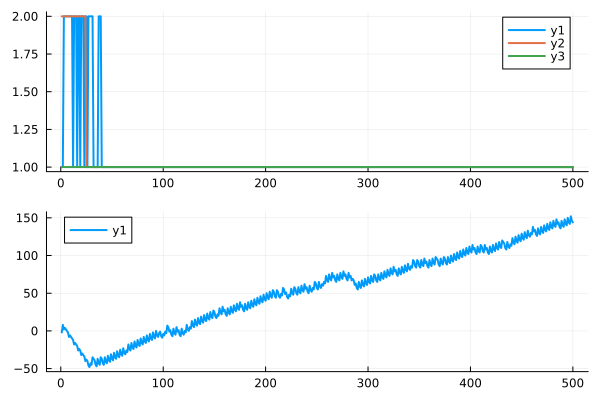

In [96]:
ag = init_greedyd(en, 0.1f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 500
acval_itr = zeros(Float32, n_itr, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, n_itr)
rew_hist = zeros(Float32, n_itr)
now_state = init_state
tot_rew = 0.0f0
for trial in 1:n_itr
    a = decide_action(ag, now_state)
    next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
    update_Q!(ag, now_state, a, en.g[a,now_state], next_state)
    for s in 1:en.s_dim
        pol_itr[s, trial] = argmax(ag.ac_valuefn[:,s])
    end
    tot_rew += en.g[a, now_state]
    rew_hist[trial] = tot_rew
    now_state = next_state
end
println(ag.ac_valuefn)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

経験論的なものとして、行動価値関数$Q$の初期値をある程度高めの値で初期化しておく("楽観的な"初期化をする)事で、最善方策の発見を早くできる事が知られている。これの初期値が高い場合と低い場合を見てみよう。(確率的に探索するので、何回か実行してみて、収束の速さを見てみる事を進める。)($\epsilon=0.2$だとランダムの確率が高いのであまり違いは見えないが、$\epsilon=0.1$くらいにすると違いが見えたりする。)

理屈としては、「初期化の値が低いと、最初に試した行動よりも他の行動の評価値が低いので、最初に試した行動のみを繰り返してしまい、結果として探索がほとんど進まず最善方策を見つけるのが遅れ、長期的に見てもトータルの報酬が低くなってしまう」というったメカニズムである。(知見としては、「あんまり自分の経験のないものを見下さず(低めの評価をつけず)、一旦試してみる方が長期的には良かったりする」的な経験論だったりする。)

Float32[17.807373 25.501884 25.604595; 5.402476 17.5143 29.067312]
Float32[1.0 1.0 0.0; 0.0 0.0 1.0]


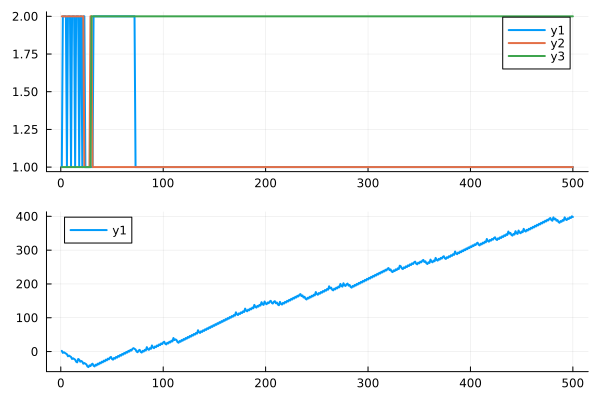

In [95]:
ag = init_greedyd_opt(en, 10.0f0, 0.1f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 500
acval_itr = zeros(Float32, n_itr, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, n_itr)
rew_hist = zeros(Float32, n_itr)
now_state = init_state
tot_rew = 0.0f0
for trial in 1:n_itr
    a = decide_action(ag, now_state)
    next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
    update_Q!(ag, now_state, a, en.g[a,now_state], next_state)
    for s in 1:en.s_dim
        pol_itr[s, trial] = argmax(ag.ac_valuefn[:,s])
    end
    tot_rew += en.g[a, now_state]
    rew_hist[trial] = tot_rew
    now_state = next_state
end
println(ag.ac_valuefn)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

Float32[2.5717394 9.363577 12.147319; -1.785541 2.5472925 10.827556]
Float32[1.0 1.0 1.0; 0.0 0.0 0.0]


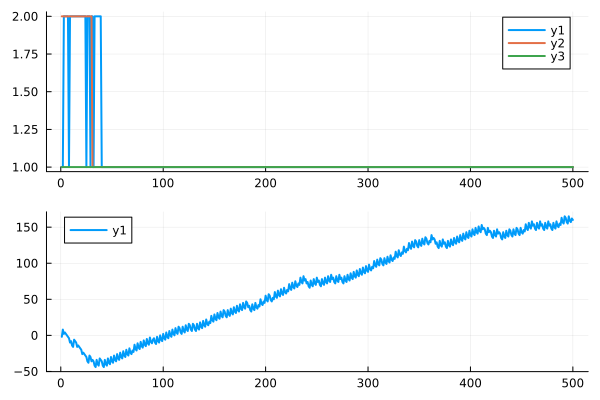

In [99]:
ag = init_greedyd_opt(en, -10.0f0, 0.1f0, 0.95f0, 0.2f0)
init_state = 2
n_itr = 500
acval_itr = zeros(Float32, n_itr, en.a_dim, en.s_dim)
pol_itr = zeros(Int, en.s_dim, n_itr)
rew_hist = zeros(Float32, n_itr)
now_state = init_state
tot_rew = 0.0f0
for trial in 1:n_itr
    a = decide_action(ag, now_state)
    next_state = sample(1:en.s_dim, ProbabilityWeights(en.pt[a,now_state,:]))
    update_Q!(ag, now_state, a, en.g[a,now_state], next_state)
    for s in 1:en.s_dim
        pol_itr[s, trial] = argmax(ag.ac_valuefn[:,s])
    end
    tot_rew += en.g[a, now_state]
    rew_hist[trial] = tot_rew
    now_state = next_state
end
println(ag.ac_valuefn)
println(final_policy(ag))
p1 = plot(pol_itr', lw=2.0)
p2 = plot(rew_hist, lw=2.0)
plot(p1, p2, layout=(2,1))

### 2-3. SARSA法

前回の$\epsilon$-greedy法においては、

### 2-4. Actor-Critic法

###  2-5. Monte-Carlo Tree Search

## 3. ニューラルネットによる関数近似

### 3-1. deep-Q net(with SARSA)

### 3-2. Dual Network(with Actor-Critic)

### 3-3. TRPO(Trust Region Policy Optimization)

### 3-4. PPO(Proximal Policy Optimization)

### 3-5. Alpha Zero